Working with Python 3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


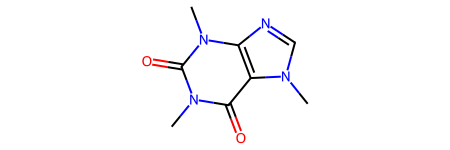

In [1]:
import sys
print(f'Working with Python {sys.version}')

import numpy as np
import pandas as pd
import importlib
#import swifter
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import time
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import rdkit.Chem.Descriptors as Descriptors
from rdkit.Chem import PandasTools
#!pip install spektral


# Deep Learning
import sklearn
#import spektral
from sklearn.model_selection import train_test_split
# Keras
from sklearn.model_selection import train_test_split
#import stellargraph as sg
from rdkit import RDLogger


#
# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
import modules.IO.mspReader as mspReader
import modules.visualization.spectrum_visualizer as sv
import modules.IO.molReader as molReader


RDLogger.DisableLog('rdApp.*')


caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
caffeine_mol = Chem.MolFromSmiles(caffeine_smiles)

caffeine_mol

In [ ]:
library_name = "nist_msms"
library_directory = f"{home}/data/metabolites/NIST17/msp/nist_msms/"
!ls $library_directory

## Spectral Library
### Library loading process
Load NIST17 (*nist_msms.msp*)

In [ ]:
nist_msp = mspReader.read(library_directory + library_name + '.MSP')
df_nist = pd.DataFrame(nist_msp)

#df_nist['mol'] = df_nist['SMILES'].apply(Chem.MolFromSmiles)
#df_nist.dropna(inplace=True)
print(f"Spectral file loaded with {df_nist.shape[0]} entries and {df_nist.shape[1]} variables")


In [ ]:
# Example
EXAMPLE_ID = 32271
x = df_nist.loc[EXAMPLE_ID]
print(x)

### Library filtering process
Plot statistics and define filters for target spectra

In [8]:
# Define figure styles
color_palette = sns.color_palette("magma_r", 8)
sns.set_theme(style="whitegrid",
                  rc={'axes.edgecolor': 'black', 'ytick.left': True, 'xtick.bottom': True, 'xtick.color': 'black',
                      "axes.spines.bottom": True, "axes.spines.right": True, "axes.spines.top": True,
                      "axes.spines.left": True})


In [ ]:


fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), gridspec_kw={'width_ratios': [1, 2]}, sharey=True)
fig.set_tight_layout(False)
for ax in axs:
    ax.tick_params('x', labelrotation=45)

sns.countplot(ax=axs[0], data=df_nist, x='Spectrum_type', edgecolor="black", palette=color_palette)
sns.countplot(ax=axs[1], data=df_nist, x='Precursor_type', edgecolor="black", palette=color_palette, order=df_nist['Precursor_type'].value_counts().iloc[:8].index)
axs[0].set_ylim(0, 500000)
axs[1].set_ylabel("")

plt.show()


In [ ]:
# Filters
df_nist = df_nist[df_nist["Spectrum_type"] == "MS2"]
target_precursor_type = ["[M+H]+", "[M-H]-", "[M+H-H2O]+", "[M+Na]+"]
df_nist = df_nist[df_nist["Precursor_type"].apply(lambda ptype: ptype in target_precursor_type)]

# Formats
df_nist['PrecursorMZ'] = df_nist["PrecursorMZ"].astype('float')
df_nist['Num peaks'] = df_nist["Num peaks"].astype('int')


print(f"Spectral file filtered down to {df_nist.shape[0]} entries")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), gridspec_kw={'width_ratios': [1, 2]}, sharey=False)
for ax in axs:
    ax.tick_params('x', labelrotation=45)

sns.boxplot(ax=axs[0], data=df_nist, y='PrecursorMZ', palette=color_palette, x="Precursor_type")
sns.histplot(ax=axs[1], data=df_nist, x='Num peaks', color=color_palette[7], fill=True, edgecolor="black")#, order=list(range(0,200)))
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['axes.edgecolor'] = 'black'
axs[1].set_ylabel("")
axs[1].set_xlim([0, 100])
axs[1].axvline(x=50, color="red", linestyle="-.")

plt.show()

In [ ]:
# associate MOL structures with MS2 spectra

file = library_directory + library_name + ".MOL/" + "S" + x["CASNO"] + ".MOL"
x_mol = molReader.load_MOL(file)
x_mol

fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)

img = Chem.Draw.MolToImage(x_mol, ax=axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title(x["Name"]+ " structure:\n" + Chem.MolToSmiles(x_mol))
axs[0].imshow(img)
axs[0].axis("off")
sv.plot_spectrum(title=x["Name"] + " MS/MS spectrum", spectrum=x, ax=axs[1])


In [ ]:

#print(df_nist.loc[1474])

print("Reading structure information in MOL format from library files (this may take a while)")
def fetch_mol(data):
    file = library_directory + library_name + ".MOL/" + "S" + str(data["CASNO"]) + ".MOL"
    if not os.path.exists(file):
        file = library_directory + library_name + ".MOL/" + "ID" + str(data["ID"]) + ".MOL"
    return molReader.load_MOL(file)

df_nist= df_nist[~df_nist["InChIKey"].isnull()] # Drop all without key (Not neccessarily neccesary)
df_nist["MOL"] = df_nist.apply(fetch_mol, axis=1)
print(f"Successfully interpreted {sum(df_nist['MOL'].notna())} from {df_nist.shape[0]} entries. Dropping the rest.")

df_nist = df_nist[df_nist['MOL'].notna()]
df_nist["SMILES"] = df_nist["MOL"].apply(Chem.MolToSmiles)
df_nist["InChI"] = df_nist["MOL"].apply(Chem.MolToInchi)
df_nist["K"] = df_nist["MOL"].apply(Chem.MolToInchiKey)
df_nist["ExactMolWeight"] = df_nist["MOL"].apply(Chem.Descriptors.ExactMolWt)


In [ ]:
print(df_nist[df_nist["Name"] == example_entry].iloc[0])
print(len(df_nist["MOL"].unique()))


df_nist.shape
df_nist["SMILES"].isnull().any()

df_nist[df_nist["Name"] == example_entry].iloc[0]["SMILES"]

In [ ]:
correct_keys = df_nist.apply(lambda x: x["InChIKey"] == x["K"], axis=1)
s = "confirmed!" if correct_keys.all() else "not confirmed !! Attention!"
print(f"Confirming whether computed and provided InChI-Keys are correct. Result: {s} ({correct_keys.sum()/len(correct_keys):0.2f} correct)")
half_keys = df_nist.apply(lambda x: x["InChIKey"].split('-')[0] == x["K"].split('-')[0], axis=1)
s = "confirmed!" if half_keys.all() else "not confirmed !! Attention!"
print(f"Checking if main layer InChI-Keys are correct. Result: {s} ({half_keys.sum()/len(half_keys):0.3f} correct)")

print("Dropping all other.")
df_nist["matching_key"] = df_nist.apply(lambda x: x["InChIKey"] == x["K"], axis=1)
df_nist = df_nist[df_nist["matching_key"]]

print(f"Shape: {df_nist.shape}")

In [16]:
df_nist["ExactMolWeight"] = df_nist["MOL"].apply(Chem.Descriptors.ExactMolWt)

In [17]:
df_unfiltered = df_nist.copy(deep=True)

### Filtering
Introduce harsh filters to produce a high quality sample.

In [ ]:
MIN_PEAKS = 2
MAX_PEAKS = 30
PRECURSOR_TYPES = ["[M+H]+"]
from modules.MOL.constants import ADDUCT_WEIGHTS



df_nist = df_nist[df_nist["Num peaks"] > MIN_PEAKS]
df_nist = df_nist[df_nist["Num peaks"] < MAX_PEAKS] #TODO WHY MAX CUTOFF: REMOVE!!
df_nist["theoretical_precursor_mz"] = df_nist["ExactMolWeight"] + df_nist["Precursor_type"].map(ADDUCT_WEIGHTS)
df_nist = df_nist[df_nist["Precursor_type"].apply(lambda ptype: ptype in PRECURSOR_TYPES)]
df_nist["precursor_offset"] = df_nist["PrecursorMZ"] - df_nist["theoretical_precursor_mz"]

print(f"Shape {df_nist.shape}")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), gridspec_kw={'width_ratios': [1, 1.5]}, sharey=False)
for ax in axs:
    ax.tick_params('x', labelrotation=45)

sns.scatterplot(ax=axs[0], data=df_nist,x="precursor_offset", y='PrecursorMZ', palette=color_palette)
sns.histplot(ax=axs[1], data=df_nist, x='precursor_offset', color=color_palette[7], fill=True, edgecolor="black")#, order=list(range(0,200)))
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['axes.edgecolor'] = 'black'
axs[1].set_ylabel("")
#axs[1].set_xlim([0, 100])
#axs[1].axvline(x=50, color="red", linestyle="-.")

plt.show()

#### Align and filter Collision Energy

443 unqiue CE
Q: How to align different CE, INT, INTeV, %, ...

In [25]:
df_nist.columns

Index(['Name', 'Synon', 'Notes', 'Precursor_type', 'Spectrum_type',
       'PrecursorMZ', 'Instrument_type', 'Instrument', 'Sample_inlet',
       'Ionization', 'Collision_energy', 'Ion_mode', 'Special_fragmentation',
       'InChIKey', 'Formula', 'MW', 'ExactMass', 'CASNO', 'NISTNO', 'ID',
       'Comment', 'Num peaks', 'peaks', 'Link', 'Related_CAS#',
       'Collision_gas', 'Pressure', 'In-source_voltage', 'msN_pathway', 'MOL',
       'SMILES', 'InChI', 'K', 'ExactMolWeight', 'matching_key',
       'theoretical_precursor_mz', 'precursor_offset'],
      dtype='object')

In [ ]:
# TODO Use more Collision energy types. eg. ramps, stepped, resonant...

from modules.MOL.collision_energy import align_CE

df_nist["CE"] = df_nist.apply(lambda x: align_CE(x["Collision_energy"], x["theoretical_precursor_mz"]), axis=1) #modules.MOL.collision_energy.align_CE) 
df_nist["CE_type"] = df_nist["CE"].apply(type)
df_nist["CE_derived_from_NCE"] = df_nist["Collision_energy"].apply(lambda x: "%" in str(x))
# df_test = df_nist[df_nist["Collision_energy"].apply(lambda x: "%" in str(x))]["Collision_energy"]
# df_test = df_test.apply(lambda x: x.split('%')[0].strip().split(' ')[-1])
# for d in df_test:
#     try: 
#         float(d)
#     except:
#         print(d)
# TODO FIND MORE CE derived from different NCE types

print("Distinguish CE absolute values (eV - float) and normalized CE (in % - str format)")
print(df_nist["CE_type"].value_counts())

print("Removing all but absolute values")
df_nist = df_nist[df_nist["CE_type"] == float]
df_nist = df_nist[~df_nist["CE"].isnull()]
#len(df_nist['CE'].unique())

print(f'Detected {len(df_nist["CE"].unique())} unique collision energies in range from {np.min(df_nist["CE"])} to {max(df_nist["CE"])} eV')


In [ ]:
df_nist[df_nist["Instrument_type"] =="HCD"]["Collision_energy"].value_counts()[:100]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))
#for ax in axs:
#    ax.tick_params('x', labelrotation=45)

#sns.scatterplot(ax=axs[0], data=df_nist,x="precursor_offset", y='PrecursorMZ', palette=color_palette)
sns.histplot(ax=ax, data=df_nist, x='CE', hue="CE_derived_from_NCE", palette=[color_palette[4], color_palette[2]], multiple="stack", fill=True, binwidth=2, edgecolor="black", binrange=[0, 200])#, order=list(range(0,200)))
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['axes.edgecolor'] = 'black'
plt.show()
print(f"{df_nist.shape[0]} spectra remaining with aligned absolute collision energies")

### Matching 1st-order peaks 
Matching first order peaks to molecule fragments by cutting a single edge. First build an *in silico* fragmentation tree for each molecular structure, but cutting edges in the molecular structure graph. Then, fragments ion masses are compared to peaks in the mass spectrum.
#### Graph representation
Creating molecular structure graph

In [ ]:
%%capture
from modules.MOL.Metabolite import Metabolite
from modules.MOL.constants import PPM
TOLERANCE = 200 * PPM


df_nist["Metabolite"] = df_nist["SMILES"].apply(Metabolite)
df_nist["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())
df_nist["Metabolite"].apply(lambda x: x.compute_graph_attributes())
df_nist["Metabolite"].apply(lambda x: x.fragment_MOL())
df_nist.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=TOLERANCE), axis=1)

In [ ]:
from modules.MOL.mol_graph import draw_graph
x = df_nist.loc[EXAMPLE_ID]

fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), gridspec_kw={'width_ratios': [1, 1]}, sharey=False)

img = Chem.Draw.MolToImage(x_mol, ax=axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title(x["Name"]+ " structure:\n" + Chem.MolToSmiles(x_mol))
axs[0].imshow(img)
axs[0].axis("off")

g_img = draw_graph(x["Metabolite"].Graph, ax=axs[1])
print(x["peaks"])

In [ ]:
# import modules.IO.fraggraphReader as fraggraphReader
# from modules.MS.ms_utility import find_matching_peaks, match_fragment_lists

# from modules.MOL.FragmentationTree import FragmentationTree


# f = fraggraphReader.parser_fraggraph_gen(library_directory + "examples/CNCCCN1c2ccccc2CCc2ccccc21_fraggraph.txt")
# x = df_nist.loc[EXAMPLE_ID]

# match_fragment_lists(x["peaks"]["mz"], f["fragments"]["mass"])

### Fragmentation Trees
Compute fragmentation tree, by single edge breaks of non-ring bonds.

In [ ]:

x = df_nist.loc[EXAMPLE_ID]

FT = x["Metabolite"].fragmentation_tree
#frag.build_fragmentation_tree_by_rotatable_bond_breaks()
print(FT)

fig, axs = plt.subplots(1, 2, figsize=(12.8, 2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)

img = Chem.Draw.MolToImage(x["MOL"], ax=axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title(x["Name"]+ " structure:\n" + x["SMILES"])
axs[0].imshow(img)
axs[0].axis("off")
sv.plot_spectrum(title=x["Name"] + " MS/MS spectrum", spectrum=x, ax=axs[1])

print("Matching peaks to fragments")
print(x["Metabolite"].peak_matches)


### Match fragments and peaks

In [ ]:
from modules.MOL.constants import DEFAULT_MODES
df_nist["peak_matches"] = df_nist["Metabolite"].apply(lambda x: getattr(x, "peak_matches"))
df_nist["num_peaks_matched"] = df_nist["peak_matches"].apply(len)

def get_match_stats(matches, mode_count={m: 0 for m in DEFAULT_MODES}):
    num_unique, num_conflicts = 0, 0
    for mz, match_data in matches.items():
        #candidates = match_data["fragments"]
        ion_modes = match_data["ion_modes"]
        if len(ion_modes) == 1:
            num_unique += 1
        elif len(ion_modes) > 1:
            num_conflicts += 1
        for c in ion_modes:
            mode_count[c[0]] += 1
    return num_unique, num_conflicts, mode_count



df_nist["match_stats"] = df_nist["peak_matches"].apply(lambda x: get_match_stats(x))
df_nist["num_unique_peaks_matched"] = df_nist.apply(lambda x: x["match_stats"][0], axis=1)
df_nist["num_conflicts_in_peak_matching"] = df_nist.apply(lambda x: x["match_stats"][1], axis=1)
df_nist["match_mode_counts"] = df_nist.apply(lambda x: x["match_stats"][2], axis=1)
u= df_nist["num_unique_peaks_matched"].sum() 
s= df_nist["num_conflicts_in_peak_matching"].sum() 
print(f"Total number of uniquely matched peaks: {u} , conflicts found within {s} matches ({100 * s / (u+s):.02f} %))")
print(f"Total number of conflicting peak to fragment matches: {s}")

df_nist.shape
 

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12.8, 6.4), sharey=False)

fig.suptitle(f"Identified peaks with fragment offset")
#plt.title(f"Identified peaks with fragment offset: {str(off)}")
sns.histplot(ax=axs[0],data=df_nist, x="num_peaks_matched", color=color_palette[0], edgecolor="black", bins=range(0,20, 1))
#axs[0].set_ylim(-0.5, 10)
axs[0].set_ylabel("peaks identified")


sns.boxplot(ax=axs[1],data=df_nist, y="num_unique_peaks_matched", color=color_palette[1])
axs[1].set_ylim(-0.5, 15)
axs[1].set_xlabel("unique matches")
axs[1].set_ylabel("")


sns.boxplot(ax=axs[2],data=df_nist, y="num_conflicts_in_peak_matching", color=color_palette[3])
axs[2].set_ylim(-0.5, 15)
axs[2].set_xlabel("conflicts")
axs[2].set_ylabel("")

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)

mode_counts = {m: 0 for m in DEFAULT_MODES}

def update_mode_counts(m):
    for mode in m.keys():
        mode_counts[mode] += m[mode]

df_nist["match_mode_counts"].apply(update_mode_counts)

sns.barplot(ax=axs[0], x=list(mode_counts.keys()), y=[mode_counts[k] for k in mode_counts.keys()], palette=color_palette, edgecolor="black", linewidth=1.5)
axs[1].pie([mode_counts[k] for k in mode_counts.keys()], labels=list(mode_counts.keys()), colors=color_palette, wedgeprops={"edgecolor": "black", "linewidth": 1.5})

plt.show()

In [ ]:

for i in range(0,6):
    print(f"Minimum {i} unique peaks identified (including precursors): ", (df_nist["num_unique_peaks_matched"] >= i).sum())


Save dataframe to file

#### [M-H]-
Let's test negative mode ions

In [ ]:
df_minus = df_unfiltered.copy(deep=True)

MIN_PEAKS = 2
MAX_PEAKS = 30
PRECURSOR_TYPES = ["[M-H]-"]
from modules.MOL.constants import ADDUCT_WEIGHTS



df_minus = df_minus[df_minus["Num peaks"] > MIN_PEAKS]
df_minus = df_minus[df_minus["Num peaks"] < MAX_PEAKS] #TODO WHY MAX CUTOFF: REMOVE!!
df_minus["theoretical_precursor_mz"] = df_minus["ExactMolWeight"] + df_minus["Precursor_type"].map(ADDUCT_WEIGHTS)
df_minus = df_minus[df_minus["Precursor_type"].apply(lambda ptype: ptype in PRECURSOR_TYPES)]
df_minus["precursor_offset"] = df_minus["PrecursorMZ"] - df_minus["theoretical_precursor_mz"]

print(f"Shape {df_minus.shape}")

#### Align and filter Collision Energy

443 unqiue CE
Q: How to align different CE, INT, INTeV, %, ...

In [ ]:

# TODO Use more Collision energy types. eg. ramps, stepped, resonant...

from modules.MOL.collision_energy import NCE_to_eV#align_CE,


df_minus["CE"] = df_minus.apply(lambda x: align_CE(x["Collision_energy"], x["theoretical_precursor_mz"]), axis=1) #modules.MOL.collision_energy.align_CE) 
df_minus["CE_type"] = df_minus["CE"].apply(type)
df_minus["CE_derived_from_NCE"] = df_minus["Collision_energy"].apply(lambda x: "%" in str(x))


print("Distinguish CE absolute values (eV - float) and normalized CE (in % - str format)")
print(df_minus["CE_type"].value_counts())

print("Removing all but absolute values")
df_minus = df_minus[df_minus["CE_type"] == float]
df_minus = df_minus[~df_minus["CE"].isnull()]
#len(df_nist['CE'].unique())

print(f'Detected {len(df_minus["CE"].unique())} unique collision energies in range from {np.min(df_minus["CE"])} to {max(df_minus["CE"])} eV')


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))
#for ax in axs:
#    ax.tick_params('x', labelrotation=45)

#sns.scatterplot(ax=axs[0], data=df_nist,x="precursor_offset", y='PrecursorMZ', palette=color_palette)
sns.histplot(ax=ax, data=df_minus, x='CE', hue="CE_derived_from_NCE", palette=[color_palette[4], color_palette[2]], multiple="stack", fill=True, binwidth=2, edgecolor="black", binrange=[0, 200])#, order=list(range(0,200)))
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['axes.edgecolor'] = 'black'
plt.show()
print(f"{df_minus.shape[0]} spectra remaining with aligned absolute collision energies")

### Matching 1st-order peaks 
Matching first order peaks to molecule fragments by cutting a single edge. First build an *in silico* fragmentation tree for each molecular structure, but cutting edges in the molecular structure graph. Then, fragments ion masses are compared to peaks in the mass spectrum.
#### Graph representation
Creating molecular structure graph

In [ ]:
%%capture
df_minus["Metabolite"] = df_minus["SMILES"].apply(Metabolite)
df_minus["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())
df_minus["Metabolite"].apply(lambda x: x.compute_graph_attributes())
df_minus["Metabolite"].apply(lambda x: x.fragment_MOL())
#df_minus["Metabolite"].apply(lambda x: x.fragmentation_tree.set_fragment_modes(constants.NEGATIVE_MODES))

df_minus.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=TOLERANCE), axis=1)

### Fragmentation Trees
Compute fragmentation tree, by single edge breaks of non-ring bonds.

### Match fragments and peaks

In [ ]:


df_minus["peak_matches"] = df_minus["Metabolite"].apply(lambda x: getattr(x, "peak_matches"))
df_minus["num_peaks_matched"] = df_minus["peak_matches"].apply(len)



df_minus["match_stats"] = df_minus["peak_matches"].apply(lambda x: get_match_stats(x))
df_minus["num_unique_peaks_matched"] = df_minus.apply(lambda x: x["match_stats"][0], axis=1)
df_minus["num_conflicts_in_peak_matching"] = df_minus.apply(lambda x: x["match_stats"][1], axis=1)
df_minus["match_mode_counts"] = df_minus.apply(lambda x: x["match_stats"][2], axis=1)
u= df_minus["num_unique_peaks_matched"].sum() 
s= df_minus["num_conflicts_in_peak_matching"].sum() 
print(f"Total number of uniquely matched peaks: {u} , conflicts found within {s} matches ({100 * s / (u+s):.02f} %))")
print(f"Total number of conflicting peak to fragment matches: {s}")

df_minus.shape
 

Total number of uniquely matched peaks: 112203 , conflicts found within 23450 matches (17.29 %))
Total number of conflicting peak to fragment matches: 23450


(27950, 47)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12.8, 6.4), sharey=False)

fig.suptitle(f"Identified peaks with fragment offset")
#plt.title(f"Identified peaks with fragment offset: {str(off)}")
sns.histplot(ax=axs[0],data=df_minus, x="num_peaks_matched", color=color_palette[0], edgecolor="black", bins=range(0,20, 1))
#axs[0].set_ylim(-0.5, 10)
axs[0].set_ylabel("peaks identified")


sns.boxplot(ax=axs[1],data=df_minus, y="num_unique_peaks_matched", color=color_palette[1])
axs[1].set_ylim(-0.5, 15)
axs[1].set_xlabel("unique matches")
axs[1].set_ylabel("")


sns.boxplot(ax=axs[2],data=df_minus, y="num_conflicts_in_peak_matching", color=color_palette[3])
axs[2].set_ylim(-0.5, 15)
axs[2].set_xlabel("conflicts")
axs[2].set_ylabel("")

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)

mode_counts = {m: 0 for m in DEFAULT_MODES}

def update_mode_counts(m):
    for mode in m.keys():
        mode_counts[mode] += m[mode]

df_minus["match_mode_counts"].apply(update_mode_counts)

mode_counts = dict((key.replace("]+", "]-"), value) for (key, value) in mode_counts.items())

sns.barplot(ax=axs[0], x=list(mode_counts.keys()), y=[mode_counts[k] for k in mode_counts.keys()], palette=color_palette, edgecolor="black", linewidth=1.5)
axs[1].pie([mode_counts[k] for k in mode_counts.keys()], labels=list(mode_counts.keys()), colors=color_palette, wedgeprops={"edgecolor": "black", "linewidth": 1.5})

plt.show()

In [ ]:

for i in range(0,6):
    print(f"Minimum {i} unique peaks identified (including precursors): ", (df_minus["num_unique_peaks_matched"] >= i).sum())


### CONCATENATE + and - modes

In [ ]:
df = pd.concat([df_nist, df_minus], axis=0)

df["Precursor_type"].value_counts()

In [ ]:

for i in range(0,6):
    print(f"Minimum {i} unique peaks identified (including precursors): ", (df["num_unique_peaks_matched"] >= i).sum())


In [ ]:
save_df = False
name = "nist_msms_filtered"
date = "XXX" #"07_2023"
min_peaks = 1

if save_df:
       key_columns = ['Name', 'Synon', 'Notes', 'Precursor_type', 'Spectrum_type',
              'PrecursorMZ', 'Instrument_type', 'Instrument', 'Sample_inlet',
              'Ionization', 'Collision_energy', 'Ion_mode', 'Special_fragmentation',
              'InChIKey', 'Formula', 'MW', 'ExactMass', 'CASNO', 'NISTNO', 'ID',
              'Comment', 'Num peaks', 'peaks', 'Link', 'Related_CAS#',
              'Collision_gas', 'Pressure', 'In-source_voltage', 'msN_pathway', 'MOL',
              'SMILES', 'InChI', 'K', 'ExactMolWeight', 'matching_key',
              'theoretical_precursor_mz', 'precursor_offset', 'CE', 'CE_type', 'peak_matches',
              'num_peaks_matched', 'match_stats', 'num_unique_peaks_matched',
              'num_conflicts_in_peak_matching', 'match_mode_counts']
       file = library_directory + name + "_min" + str(min_peaks) + "_" + date + ".csv"
       print("saving to ", file)
       df[df["num_unique_peaks_matched"] >= min_peaks][key_columns].to_csv(file)
       
       #df[key_columns].to_csv(library_directory + name + "all" + "_" + date + ".csv")